🚀 LangGraph Quickstart : https://langchain-ai.github.io/langgraph/tutorials/introduction/

# Installation

In [2]:
!pip install -U langgraph langchain-openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.9/415.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 673.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.4/567.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.44
    Uninstalling langchain-core-0.3.44:
  

In [3]:
!pip show langgraph langchain_openai langchain_community

Name: langgraph
Version: 0.3.14
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk
Required-by: 
---
Name: langchain-openai
Version: 0.3.9
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 
---
Name: langchain-community
Version: 0.3.19
Summary: Community contributed LangChain integrations.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, dataclasses-json, httpx-sse, langchain, langchain-core, langsmith, numpy, pydantic-settings, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


# Part 1: Build a Basic Chatbot

In [5]:
################################
# Part 1: Build a Basic Chatbot #
################################

# Start by creating a StateGraph, A State object defines the structure
# of our chabot as "state machine", We'll add `nodes` to represent the llm
# and functions our chatbot can call and `edges` to specifiy how the bot
# should transition between these functions

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from google.colab import userdata

class State(TypedDict):
    # Message have the type "list", The "add_messages" function
    # in the annotation defines how this state should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

def chatbot(state: State):
    # Notice how the chatbot node function takes the current `State` as
    # input adn returns a dictionary containing an updated `messages` list under the key "messages".
    # This is the basic pattern for all LangGraph node functions
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used
graph_builder.add_node("chatbot", chatbot)
# Next, add an `entry` point.
# This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")
# Similarly, Set a finish point.
# This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)
# Finally, we'll want to be able to run our graph, call "compile()" on the graph builder.
# This creates a "CompiledGraph" we can use invoke on our state
graph = graph_builder.compile()

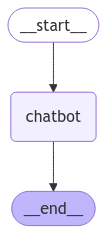

In [ ]:
# You can visualize the graph using the get_graph method and one of the "draw" methods,
# like draw_ascii or draw_png. The draw methods each require additional dependencies.
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Congratulations!!! You're built your first chatbot using LangGraph.
# This bot can engage in basic conversation by taking user input and generating responses using an LLM
# However, you may have noticed that the bot's knowledge is limited to what's in its training date. In the
# next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

# Now let's run the chatbot!!!
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I assist you today?
User: Pls introduce yourself
Assistant: Hello! I'm ChatGPT, an AI language model created by OpenAI. My purpose is to assist you by providing information, answering questions, and engaging in conversations on a wide range of topics. Whether you need help with learning, problem-solving, or just want to chat, I'm here for you. How can I assist you today?
User: thx, bye, see you later
Assistant: You're welcome! If you need anything in the future, feel free to reach out. Bye, and take care!
User: exit
Goodbye!


# Part 2: Enhancing the Chatbot with Tools

In [ ]:
###########################################
# Part 2: Enhancing the Chatbot with Tools #
###########################################

# To handle queries our chatbot can't answer "from memory",
# we'll integrate a web search tool. Our bot can use this tool
# to find relevant information and provide better responses.

from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata
import os

# Define the tool:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)
tools = [tool]
# tool.invoke("What's a `node` in LangGraph?") # The results are pages summaries

# Next, we'wll start defining our graph.
# The following is all the same as Part1, except we have added `bind_tools` on our LLM.
# This lets the LLM konw the correct JSON format to use if it wawnts to use our search engine.
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder2 = StateGraph(State)

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

llm_with_tools = llm.bind_tools(tools) # Modification: tell the LLM which tools it can call

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
# Next we need to create a function to actually run the tools if they are called.
# We'll do this by adding the tools to a new node.
# Below we implement a `BasicToolNode` that checks the most recent messages in the state
# and calls tools if the messages contains `tool_calls`. It relies on  the LLM's `tool_calling`
# support, which is available in Anthropic, OpenAI...

# We will later replace this with LangGraph's prebuilt `ToolNode` to speed
# things up, but building it ourselves first is instructive.
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """ A node that runs the tools requested in the last AIMessages """
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# Below, call define a router function called `route_tools`,
# that checks for tool_calls in the chatbot's output.
# Provide this function to the graph by calling `add_conditonal_edges`,
# which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

# The condition will route to `tools` if tool calls are present and `END` if not.
# Later, we will replace this with the prebuilt `tools_condition` to be more concise,
# but implementing it ourselves first makes things more clear.
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [ ]:
graph_builder2.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools=[tool])
graph_builder2.add_node("tools", tool_node)
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool
# and "END" if it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder2.add_conditional_edges(
    "chatbot",
    route_tools,
    # The folloing dictionary lets you tell the graph
    # to interpret the condition's outputs as a  specific node
    # It defaults to the identity function, but if you want to use a node named something else apart from "tools",
    # you can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END}
)
# Any time a tool is called, we return to the chatbot to decide the next step
# Note that we don't need to explicity set a `finish_point` this time,
# because our graph already has a way to finish!
graph_builder2.add_edge("tools", "chatbot")
graph_builder2.add_edge(START, "chatbot")
graph = graph_builder2.compile()

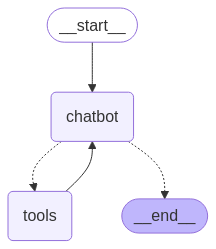

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Congrats! You've created a conversational agent in langgraph that can use a search engine to retrieve
# updated information when needed. Now it can handle a wider range of user queries.

# Now we can ask the bot questions outside its training data.
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input=user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:Pls tell me the information about the website which domain name is hackorg.com
Assistant: 
Assistant: [{"title": "Hack Organization - GitHub", "url": "https://github.com/TheHackOrg", "content": "HackOrg is a open-source & non-profit organization about hacking technique . Verified. We've verified that the organization TheHackOrg controls the domain:.", "score": 0.7728226}, {"title": "HackOrg", "url": "https://hackorg.com/", "content": "\u4e00\u4e2a\u70ed\u8877\u4e8e\u9ed1\u5ba2\u6280\u672f\u7684\u5f00\u6e90\u975e\u8425\u5229\u7ec4\u7ec7.", "score": 0.68613435}, {"title": "GameHacking.org | Home", "url": "https://gamehacking.org/", "content": "GameHacking.org is a community of video game hackers, and a place for codes, guides, tools, and more.", "score": 0.395254608}, {"title": "MC's journal", "url": "https://hack.org/mc/blog/", "content": "2015-08-30 Disk crash brought down hack.org & others. 2015-06-11 Go and xmpp ... 2012-06-19 hack.org blocked by web filtering companies. 2012-06

# Part 3: Adding Memory to the Chatbot

In [ ]:
########################################
# Part 3: Adding Memory to the Chatbot #
########################################

# Our chatbot can now use tools to answer user question, buts it doesn'ts remembers
# the context of previouss interactions. This limits its ability to have coherent, multi-turn conversations.

# LangGraph solves this problem through persistent checkpointing. If you provide a `checkpointer` when compiling
# the graph and `thread_id` when calling your graph, LangGraph automatically saves the sate after each step.
# When you invoke the graph again using the same `thread_id`, the graph loads its saved state,
# allowing the chatbot to pick up where it left off.

# We will see later that checkpointing is much more powerful than simple chat memroy - it lets
# you save and resume complex state at any time for error recovery, human-in-loop workflows,
# time travel interacions, and more. But before we get too ahead of ourselves, let's add checkpointing
# to enable multi-turn conversations.

# Notice: we're using an in-memory checkpointer. This is convenient for our tutorial(it saves it all in-memory).
# In a production application, you would like change this to use `SqliteSaver` or `PostgresSaver` and connect to
# your own DB.

# The following is all copied from Part 2.
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from google.colab import userdata
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)
tools = [tool]

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# Finally, compile the graph with the provided checkpointer
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

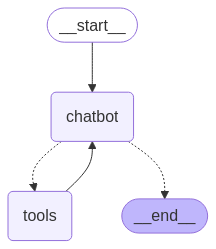

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Now you can interact with your bot! First, pick a thread to use as the key for conversation
config = {"configurable": {"thread_id": "20250317"}}
# Next, call you chat bot
user_input = "Hi there! My name is HackHuang."
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is HackHuang.
================================== Ai Message ==================================

Hello HackHuang! How can I assist you today?


In [ ]:
# Let's ask a followup: see if it remembers your name.
user_input = "Remember my name?"
# The config is the **second positional argument** to stream() or invoke().
# Notice thats we aren't using an exteral list for memory, it's all handled by the checkpointer!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, HackHuang! How can I help you today?


In [ ]:
config = {"configurable": {"thread_id": "00000000"}}
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember past interactions, including names. However, you can tell me your name, and I can use it during this conversation!


In [ ]:
# By now, we have made a few checkpoints across two different threads.
# But what goes into a checkpoint? to inspect a graph's state for a
# given config at any time, call `get_state(config)`
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='d22c1032-94a8-4ddd-9756-523684e1b5f3'), AIMessage(content="I don't have the ability to remember past interactions, including names. However, you can tell me your name, and I can use it during this conversation!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 83, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'finish_reason': 'stop', 'logprobs': None}, id='run-38ec0431-072f-4584-aeb6-3cde9e86619d-0', usage_metadata={'input_tokens': 83, 'output_tokens': 32, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

In [ ]:
# Since the graph ended this turn, `next` is empty.
# If you fetch a state from within a graph invocation, next tells which node will execute next
# In our case, the graph has reached an `END` state, so `next` is empty.
snapshot.next

()

# Part 4: Human-in-the-loop

In [ ]:
#############################
# Part 4: Human-in-the-loop #
#############################

# Agents can be unreliable and may need human input to successfully accomplish tasks.
# Similarly, for some actions, you may want to require human approval before running to
# ensure that everything is running as intended.

# LangGraph's persistence layer supports human-in-the-loop workflows, alloing exection to
# pause and resume based on user feedback. The primary interface to this functionality is
# the `interrupt`` function. Calling `interrput` inside a node will pase exection.
# Execution can be resumed, together with new input from a huam, by passing in a Command.
# `interrput` is ergonomically similar to Python's built-in `input()`.

from typing import Annotated
from langchain_community.tools.tavily_search import TavilyAnswer
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from google.colab import userdata
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Rqeuest assistance from a huamn"""
    # Similar to Pthon's built-in `input()` function, calling `interrput`
    # inside the tool will pause execution. Progress is persisted based on our choice
    # of chekpointer --- os if we are persisting with Postgres, we can resume at any time
    # as long as the database is alive. Here we are persisting with the in-memory checkpointer,
    # so we can resume any time as long as our Python Kernel is running.
    human_response = interrupt({"query": query})
    return human_response["data"]

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)

tools = [tool, human_assistance]

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

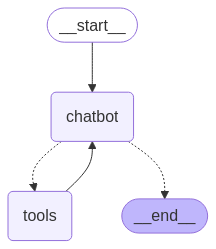

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Let's now prompt the chatbot with a question that
# will engage the new `human_assistance` tool:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_01JcXqtnPz8oGuyHBU5BVzhg)
 Call ID: call_01JcXqtnPz8oGuyHBU5BVzhg
  Args:
    query: I need expert guidance for building an AI agent. Specifically, I'm interested in the design process, technology stack options, and best practices for implementation.


In [ ]:
# The chatbot generated a tool call, but then execution has been interrputed!
# Note that if we inspect the graph state, we see that it stopped at the tools node:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [ ]:
# The resume execution, we pass a `Command` object containing data expected by the tool.
# The format of this data can be customized based on our needs, Here, we just need a dict with a key "data"
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
    "So pls introduce the LangGraph to user and give the github repo link."

)
human_command = Command(resume={"data": human_response})
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_01JcXqtnPz8oGuyHBU5BVzhg)
 Call ID: call_01JcXqtnPz8oGuyHBU5BVzhg
  Args:
    query: I need expert guidance for building an AI agent. Specifically, I'm interested in the design process, technology stack options, and best practices for implementation.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.So pls introduce the LangGraph to user and give the github repo link.
================================== Ai Message ==================================

I received expert guidance for you on building an AI agent. The experts recommend using **LangGraph**, which is considered to be more reliable and extensible than simple autonomous agents.

### What is LangGraph?

# Part 5: Customizing State

In [20]:
############################
# Part5: Customizing State #
############################

# So far, we've relied on a simple state with one entry --- a list of messages.
# You can go far with this simple state. but if you want to define complex behavior
# without relying on the message list, you can add additional fields to the state.
# Here we will demostrate a new scenario, in which the chatbot is using its search tool
# to find specific information, and forwarding them to human for review. Let's have the
# chatbot research the birthday of an entiry. We will add `nmme` and `birthday` keys to the state:

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from google.colab import userdata
import os

class State(TypedDict):
    name: str
    birthday: str
    messages: Annotated[list, add_messages]

# Here, we will populate the state keys inside of our `human_assistance` tool.
# This allows a human to review the informtion before it is stored in the state.
# We will again use `Command`, this time to issue a state update from inside our tool.
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt


# Note taht because we are generating a ToolMessage for a state update,
# we generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not be revealed to the model in the tool's schema.
@tool
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """ Request assistance from a human """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"
    # This time we explicitly update the state with ToolMessage inside the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)]
    }
    # We return a Command object in the tool to update our state
    return Command(update=state_update)

# Otherwise, the rest of our graph is the same:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)

tools = [tool, human_assistance]

llm = init_chat_model(
    model="gpt-4o",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

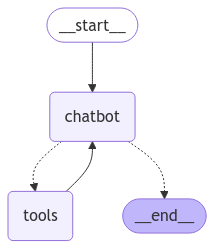

In [59]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
# Let's prompt our application to look up the "birthday" of the LangGraph
# library. We will direct the chatbot to reach out to the `huamn_assistance` tool
# once it has the requeire information. Note that setting `name` and `birthday`
# in the arguments for the tool, we forece the chatbot to generate proposals for these field.
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "20250318"}}
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rI40ljduSCGHoOZqYkUwyQDj)
 Call ID: call_rI40ljduSCGHoOZqYkUwyQDj
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "langgraph · PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearch PyPI  Search\n\nHelp\nSponsors\nLog in\nRegister\n\nMenu\n\nHelp\nSponsors\nLog in\nRegister\n\nSearch PyPI  Search\nlanggraph 0.2.70\npip install langgraph Copy PIP instructions\nLatest versionReleased: Feb 6, 2025\nBuilding stateful, multi-actor applications with LLMs\nNavigation\n\nProje

In [23]:
# The chatbot generated a tool call, but then execution has been interrputed!
# Note that if we inspect the graph state, we see that it stopped at the tools node:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [24]:
# We've hit the `interrput` in the `huamn_assistance` tool again.
# In this case, the chatbot failed to identify the correct date, so we can supply it:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_1tKCtnkavUIgtURfGZJtbfQC)
 Call ID: call_1tKCtnkavUIgtURfGZJtbfQC
  Args:
    name: LangGraph
    birthday: January 22, 2024
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [25]:
# Note that these fields are now reflected in the state.
# This makes them easily accessible to downstream nodes(e.g.., a node that further
# processes or stores the information).
snapshot = graph.get_state(config)
{k : v for k,v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [26]:
###########################
# Manually updating state #
###########################

# LangGraph gives a high degree of control over the application state.
# For instance, at any point(including when iterrupted), we can manually override a key using `graph.update_state`:
graph.update_state(config, {"name": "LangGraph(library)"})

# If we call `graph.get_state`, we can see the new value is reflected:
snapshot = graph.get_state(config)
{k:v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph(library)', 'birthday': 'Jan 17, 2024'}

# Part 6: Time Travel

In [53]:
######################
# Part6: Time Travle #
######################

# In a typical chat bot workflow, the user interacts with the bot 1 or more times
# to accomplish a task. In the previous sections, we saw how to add memory and a
# human-in-the-loop to be able to checkpoint our graph state and control future response.

# 1.But whate if you want to let your user start from a previous response and
# "brach off" to explore a separate outcome?
# 2.Or what if you want users to be able to "rewind" your assistant's work
# to fix some mistakes or try a different strategy(common in applications like autonomous software engineers?)

# You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.
# In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history`
# mehtod. You can then resume execution at this previous point in time.

# For this, let's use the simple chatbot with tools from Part3:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model
from google.colab import userdata
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = init_chat_model(
    model="gpt-4o",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

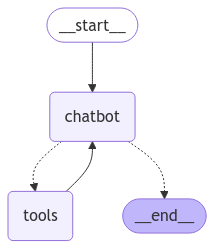

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
# Let's have our graph take a couple steps.
# Every step will be ceckpointed in its state hisotry:
config = {"configurable": {"thread_id": "88888888"}}
events = graph.stream(
    {
        "messages": [{
            "role": "user",
            "content": ("I'm learning LangGraph framework, Could you do some research on it for me?"),
        },],
    },
    config,
    stream_mode = "values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph framework, Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_35SawtST3lf3CKcSkvOFsgdi)
 Call ID: call_35SawtST3lf3CKcSkvOFsgdi
  Args:
    query: LangGraph framework
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What Is LangGraph and How to Use It? - DataCamp", "url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "Imagine you're building a complex, multi-agent large language model (LLM) application. It's exciting, but it comes with challenges: managing the state of various agents, coordinating their interactions, and handling errors effectively. This is where LangGraph can help.\nLangGraph is a library within the LangChain ecosystem designed to tackle these challeng

In [55]:
# Second conversation...
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": ("Ya that's helpful. I want to build the agent wit it, Could you do some research on it for me?"),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. I want to build the agent wit it, Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_fh5zgMNzfSOOEe0YWqBJqXHi)
 Call ID: call_fh5zgMNzfSOOEe0YWqBJqXHi
  Args:
    query: Build agent with LangGraph framework
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Tutorial: Building LLM Agents with LangChain's ... - Zep", "url": "https://www.getzep.com/ai-agents/langgraph-tutorial", "content": "| Guidelines for building LangGraph agents | LangGraph overcomes LangChain's limitations and is the recommended framework for building agentic architectures. You can integrate tools into your AI agents to provide functionality or fetch information that an LLM agent does not provide. Memory is integral t

In [56]:
# Now that we're had the agent take a couple steps,
# we can `replay` the full state history to see everything that occurred.
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next:", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the
        # number of chat messages in the state.
        to_replay = state

# Notice that checkpoints are saved for every step of the graph.
# This spans invocations so you can rewind across a full thread's history.

Num Messages:  8 Next: ()
--------------------------------------------------------------------------------
Num Messages:  7 Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next: ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next: ()
--------------------------------------------------------------------------------
Num Messages:  3 Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next: ('chatbot',)
--------------------------------------------------

In [57]:
# Resuming from this point should call the action node next.
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '88888888', 'checkpoint_ns': '', 'checkpoint_id': '1f003fe4-b984-62b7-8006-0f450da30bf9'}}


In [58]:
# Notice that the checkpoint's config(`to_replay.config`) contains a `checkpoint_id`
# timestamp. Providing this `checkpoint_id` value tells LangGraph's checkpointer to
# load the state from that moment in time. Let's try it below:

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted
# to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_fh5zgMNzfSOOEe0YWqBJqXHi)
 Call ID: call_fh5zgMNzfSOOEe0YWqBJqXHi
  Args:
    query: Build agent with LangGraph framework
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Tutorial: Building LLM Agents with LangChain's ... - Zep", "url": "https://www.getzep.com/ai-agents/langgraph-tutorial", "content": "| Guidelines for building LangGraph agents | LangGraph overcomes LangChain's limitations and is the recommended framework for building agentic architectures. You can integrate tools into your AI agents to provide functionality or fetch information that an LLM agent does not provide. Memory is integral to building production-ready AI agents, and third-party SDKs like Zep simplify adding long-term capabilities. |\nWhat is LangGraph? [...] LangGraph is an AI agent framework buil